In [1]:
from base import *
import scipy.stats

In [9]:
class Tg_plots:
    def __init__(self, catalog):
        self.full_catalog = catalog
        self.cran_cat = catalog[ catalog['has_C'] == 1 ]
        #self.catalog = catalog[ catalog['TeffH'] < 7000 ]
        self.catalog = catalog

        self.fitted_Φ = None
        self.fitted_Φ_cranmer = None
        self.fitted_Φ_error = None
        self.fitted_Φ_error_cranmer = None

        self.plotting_offset = None
        self.mode = 'normal'

    def get_fitted_Φ(self, cranmer=False):
        if cranmer:
            if self.fitted_Φ_cranmer is None:
                self.fitted_Φ_cranmer = self.fit_Φ(self.cran_cat, suffix='C')
            return self.fitted_Φ_cranmer

        if self.fitted_Φ is None:
            self.fitted_Φ = self.fit_Φ(self.catalog)
        return self.fitted_Φ

    def get_fitted_Φ_error(self, cranmer=False):
        if cranmer:
            error = self.get_fitted_Φ_error()
            return error[ self.catalog['has_C'] == 1 ]

        if self.fitted_Φ_error is None:
            c = self.catalog
            Φ = self.get_fitted_Φ()
            F8_error = c['F8'] - F8_from_logg(c['F8logg'] + c['E_F8logg'])
            error = Φ * np.sqrt(  (c['E_loggH'] / c['loggH'])**2
                            + (c['E_TeffH'] / c['TeffH'])**2
                            + (c['E_MH'] / c['MH'])**2
                            + (F8_error / c['F8'])**2 )
            self.fitted_Φ_error = error
        return self.fitted_Φ_error

    def fit_Φ(self, cat, suffix='H'):
        return fit_Φ(cat['logg' + suffix],
                     cat['Teff' + suffix],
                     cat['M' + suffix],
                     cat['F8'])

    def make_plot_fitted_cranmer(self):
        Φ = self.get_fitted_Φ(cranmer=True)

        self.plot_stat(Φ, catalog=self.cran_cat, suffix='C')
        plt.title("Fitted $\Phi$ for Cranmer et al. (2014)")

    def make_plot_model_cranmer(self):
        Ma = calc_Ma(self.cran_cat['loggC'], self.cran_cat['TeffC'])
        Φ = calc_Φ(Ma)

        self.plot_stat(Φ, catalog=self.cran_cat, suffix='C')
        plt.title("Modeled $\Phi$ for Cranmer et al. (2014)")

    def make_plot_fitted(self, **kwargs):
        Φ = self.get_fitted_Φ()

        self.plot_stat(Φ, **kwargs)
        plt.title("Fitted $\Phi$ for Bastien et al. (2016)")

    def make_plot_model(self, samadi=False):
        T = np.linspace(4500, 7000, 100)
        logg = np.linspace(1.5, 5, 100)
        TT, gg = np.meshgrid(T, logg)
        Ma = calc_Ma(gg, TT)
        Φ = calc_Φ(Ma)

        self.render_mesh_plot(TT, gg, Φ)
        self.outline_data()

        plt.title("Samadi's Model")

        if samadi:
            # Overplot Samadi's Simulated Stars
            T, logg, Θ = np.loadtxt('Samadi_2013b.txt', skiprows=2, unpack=True, usecols=(1, 3, 5))
            plt.scatter(T, logg, c=Θ / 3.21, vmin=0, vmax=2)

    def make_plot_model_theta(self, samadi=False):
        T = np.linspace(4500, 7000, 100)
        logg = np.linspace(1.5, 5, 100)
        TT, gg = np.meshgrid(T, logg)
        Ma = calc_Ma(gg, TT)
        Φ = calc_Φ(Ma)

        self.render_mesh_plot(TT, gg, Φ*3.21, cbar_label='$\Theta_{RMS}$', vmax=2*3.21)
        self.outline_data()

        plt.title("Samadi's Model")

        if samadi:
            # Overplot Samadi's Simulated Stars
            T, logg, Θ = np.loadtxt('Samadi_2013b.txt', skiprows=2, unpack=True, usecols=(1, 3, 5))
            plt.scatter(T, logg, c=Θ, vmin=0, vmax=2*3.21)

    def make_plot_model_Ma(self, samadi=False):
        max_Ma = 1
        T = np.linspace(4500, 7000, 100)
        logg = np.linspace(1.5, 5, 100)
        TT, gg = np.meshgrid(T, logg)
        Ma = calc_Ma(gg, TT)

        self.render_mesh_plot(TT, gg, Ma, cbar_label='Ma', vmax=max_Ma)
        self.outline_data()

        plt.title("Samadi's Model")

        if samadi:
            # Overplot Samadi's Simulated Stars
            T, logg, Ma = np.loadtxt('Samadi_2013b.txt', skiprows=2, unpack=True, usecols=(1, 3, 4))
            plt.scatter(T, logg, c=Ma, vmin=0, vmax=max_Ma)

    def make_plot_fitted_model(self):

        T = np.linspace(4500, 7000, 100)
        logg = np.linspace(1.5, 5, 100)
        TT, gg = np.meshgrid(T, logg)
        Φ = 2 * (gg/2.192) ** -1.1204 * (T/5110) ** -2.3446

        self.render_mesh_plot(TT, gg, Φ.T)
        self.outline_data()

        plt.title("Individual T, logg Fitting")

    def make_plot_simul_fitted_model(self, do_logg=True):
        Φ = self.get_fitted_Φ()
        error = self.get_fitted_Φ_error()

        model = lambda T_and_logg, A, B, C: A * T_and_logg[0]**B * T_and_logg[1]**C

        if do_logg:
            xdata=(self.catalog['TeffH'], self.catalog['loggH'])
        else:
            xdata=(self.catalog['TeffH'], 10**self.catalog['loggH'])

        popt, pconv = scipy.optimize.curve_fit(
                f=model,
                xdata=xdata,
                ydata=Φ,
                p0=(2*2.192*5110**2, -2.3, -1.1),
                sigma=error)

        T = np.linspace(4500, 7000, 100)
        logg = np.linspace(1.5, 5, 100)
        TT, gg = np.meshgrid(T, logg)
        if do_logg:
            fitted_Φ = model((TT, gg), *popt)
        else:
            fitted_Φ = model((TT, 10**gg), *popt)

        self.render_mesh_plot(TT, gg, fitted_Φ)
        self.outline_data()
        if do_logg:
            plt.title("Simultaneous T, logg Fitting")
            label = "{:.2G} T^{:.2F} logg^{:.2F}".format(*popt)
        else:
            plt.title("Simultaneous T, g Fitting")
            label = "{:.2G} T^{:.2F} g^{:.2F}".format(*popt)
        plt.gca().text(0.05, 0.95, label, transform=plt.gca().transAxes,
                bbox={'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'none'},
                fontsize=12)

    def plot_stat(self, z, catalog=None, suffix='H', stat='median', bins=100, log=False, zmin=None, zmax=None, **kwargs):
        if catalog is None:
            catalog = self.catalog
        x = catalog['Teff' + suffix]
        y = catalog['logg' + suffix]

        if zmin is not None:
            chop = z > zmin
            z = z[chop]
            x = x[chop]
            y = y[chop]

        if zmax is not None:
            chop = z < zmax
            z = z[chop]
            x = x[chop]
            y = y[chop]

        stat, x_edge, y_edge, binnumber = scipy.stats.binned_statistic_2d(
                x, y, z, statistic=stat, bins=bins)
        # Scipy gives us an array transposed from what a just and virtuous
        # module would give!
        stat = stat.T
        XX, YY = np.meshgrid(x_edge, y_edge)

        if log:
            stat = np.log10(stat)

        self.render_mesh_plot(XX, YY, stat, **kwargs)

    def render_mesh_plot(self, XX, YY, ZZ, vmin=0, vmax=2, vauto=False, cbar_label=None, scalings=None):
        if self.mode == 'normal':
            cmap = "viridis"
            #vmin = 0
            #vmax = 2
        elif self.mode == 'resid':
            cmap = "PRGn"
            vmin = -3
            vmax =  3
            ZZ = ZZ - self.plotting_offset
        else:
            cmap = "viridis"

        if vauto:
            good_vals = ZZ[np.isfinite(ZZ)]
            vmin = np.min(good_vals)
            vmax = np.max(good_vals)
        
        plt.pcolormesh(XX, YY, ZZ, cmap=cmap,
                vmin=vmin, vmax=vmax)

        if cbar_label is not None:
            plt.colorbar().set_label(cbar_label)
        elif self.mode == 'resid':
            plt.colorbar().set_label("$\Phi$ Residual")
        else:
            plt.colorbar().set_label("$\Phi$")
        plt.xlabel("Temperature (K)")
        plt.ylabel("log(g) (cgs)")
        # Scale to the exact edge of the data
        if scalings is not None:
            plt.xlim(*scalings[:2])
            plt.ylim(*scalings[2:])
        else:
            plt.gca().autoscale(tight=True)
            plt.gca().invert_xaxis()
            plt.gca().invert_yaxis()

    def outline_data(self, x=None, y=None, bins=100):
        if self.mode == 'resid':
            return

        if x is None:
            x = self.catalog['TeffH']
        if y is None:
            y = self.catalog['loggH']

        H, x_edge, y_edge = np.histogram2d(x, y, bins=bins)
        # Like scipy's binned stats function, this gives
        # a transposed H
        H = H.T

        # Countour plotting wants the x & y arrays to match the
        # shape of the z array, so work out the middle of each bin
        x_edge = (x_edge[1:] + x_edge[:-1]) / 2
        y_edge = (y_edge[1:] + y_edge[:-1]) / 2
        XX, YY = np.meshgrid(x_edge, y_edge)

        H[ H > 0] = 1

        plt.contour(XX, YY, H, colors='black', alpha=0.5, levels=[0.5])

    def make_all_the_plots_at_once(self, resid=False):
        if not resid:
            self.plotting_offset = 0
            self.mode = 'normal'

        counter = 0

        #plt.subplot(231 + counter)
        #self.make_plot_fitted_cranmer()
        #counter += 1

        #plt.subplot(231 + counter)
        #self.make_plot_model_cranmer()
        #counter += 1

        plt.subplot(231 + counter)
        self.make_plot_fitted()
        counter += 1

        plt.subplot(231 + counter)
        self.make_plot_model()
        counter += 1

        plt.subplot(231 + counter)
        self.make_plot_fitted_model()
        counter += 1

        plt.subplot(231 + counter)
        self.make_plot_simul_fitted_model(do_logg=True)
        counter += 1

        plt.subplot(231 + counter)
        self.make_plot_simul_fitted_model(do_logg=False)
        counter += 1

        plt.gcf().set_size_inches(18, 10)
        plt.tight_layout()
    
    def make_plots_with_slices(self):
        self.plotting_offset = 0
        self.mode = 'normal'

        # TODO: Make this work again
        # vir = colormaps.viridis
        # colormaps.viridis = 'jet'

        counter = 0

        plt.subplot(421 + counter)
        min, max = 0, 0.5
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 0.5, 1
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 1, 1.5
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 1.5, 2
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 2, 2.5
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 2.5, 3
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        plt.subplot(421 + counter)
        min, max = 3, 3.5
        self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        counter += 1

        #plt.subplot(421 + counter)
        #min, max = 3.5, 4
        #self.make_plot_fitted(zmin=min, zmax=max, vmin=0, vmax=2, scalings=(7200, 4500, 4.7, 1.6))
        #counter += 1

        plt.gcf().set_size_inches(7, 13)
        plt.tight_layout()

    def make_plots_to_compare_samadi(self):
        self.plotting_offset = 0
        self.mode = 'normal'
        
        # TODO: Make this work again
        
        # vir = colormaps.viridis
        # colormaps.viridis = 'jet'

        counter = 0

        plt.subplot(221 + counter)
        self.make_plot_fitted()
        counter += 1

        plt.subplot(221 + counter)
        self.make_plot_model(samadi=True)
        counter += 1

        plt.subplot(221 + counter)
        self.make_plot_model_Ma(samadi=True)
        counter += 1

        plt.subplot(221 + counter)
        self.make_plot_model_theta(samadi=True)
        counter += 1

        plt.gcf().set_size_inches(12, 10)
        plt.tight_layout()

        # colormaps.viridis = vir

    def make_all_the_plots_at_once_resid(self):
        Φ = self.get_fitted_Φ()
        x = self.catalog['TeffH']
        y = self.catalog['loggH']
        stat, x_edge, y_edge, binnumber = scipy.stats.binned_statistic_2d(
                x, y, Φ, statistic='median', bins=100)

        self.plotting_offset = stat.T
        self.mode = 'resid'

        self.make_all_the_plots_at_once(resid=True)

    def make_stat_plots(self):
        self.plotting_offset = None
        self.mode = 'stats'

        Φ = self.get_fitted_Φ()

        plt.subplot(221)
        self.plot_stat(Φ, stat='mean')
        plt.title("Mean")

        plt.subplot(222)
        self.plot_stat(Φ, stat='median')
        plt.title("Median")

        plt.subplot(223)
        self.plot_stat(Φ, stat='count', vauto=True, log=True)
        plt.title("log(Count)")

        plt.gcf().set_size_inches(12, 10)
        plt.tight_layout()

In [10]:
plotter = Tg_plots(catalog)

/home/sam/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in power
/home/sam/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in multiply
/home/sam/.anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:459: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


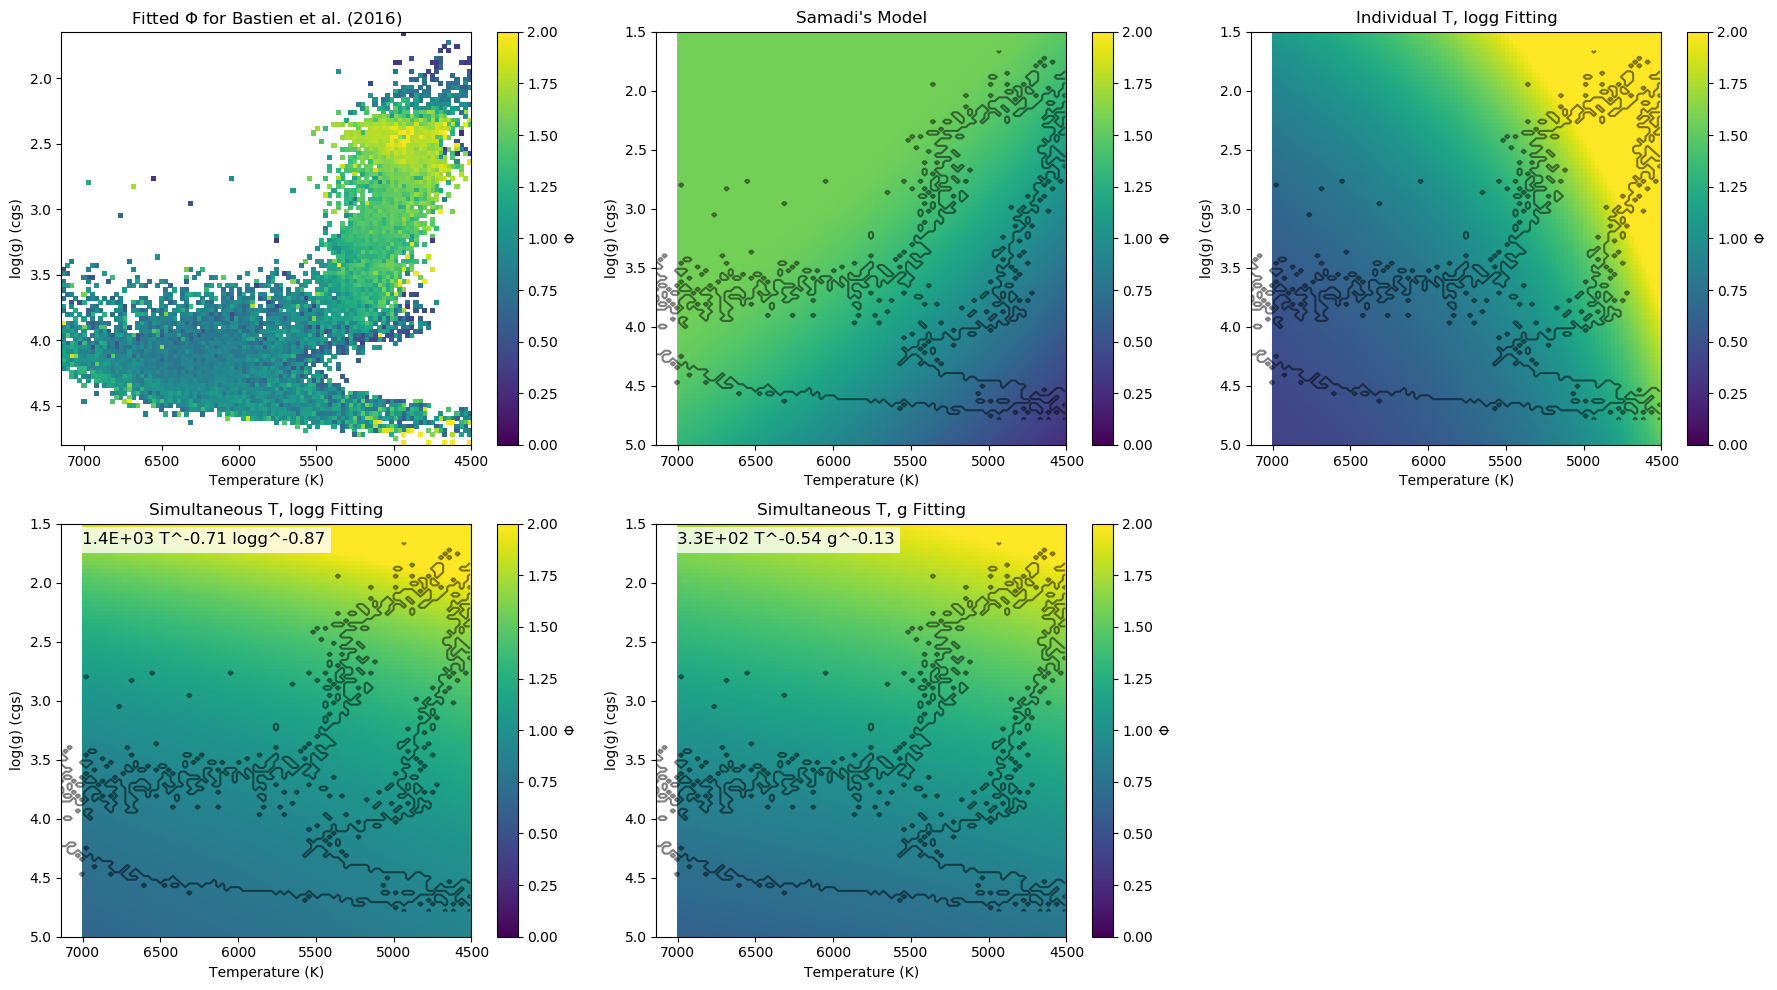

In [4]:
plotter.make_all_the_plots_at_once()
#plt.savefig("fitting_phi_Tg.png", dpi=200)
plt.show()

/home/sam/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log10


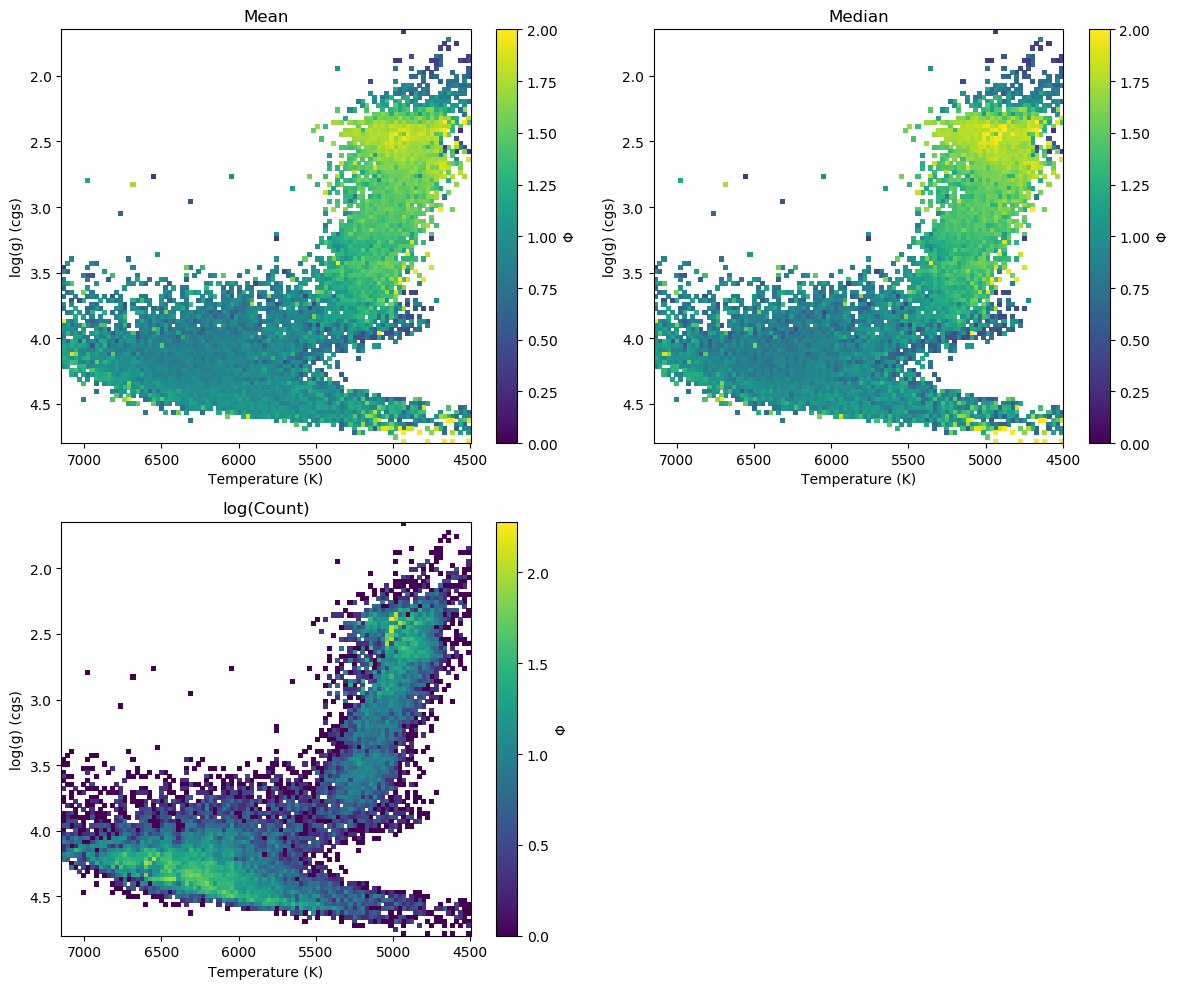

In [5]:
plotter.make_stat_plots()
#plt.savefig("fitting_phi_Tg_stats.png", dpi=200)
plt.show()

/home/sam/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in power
/home/sam/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in multiply


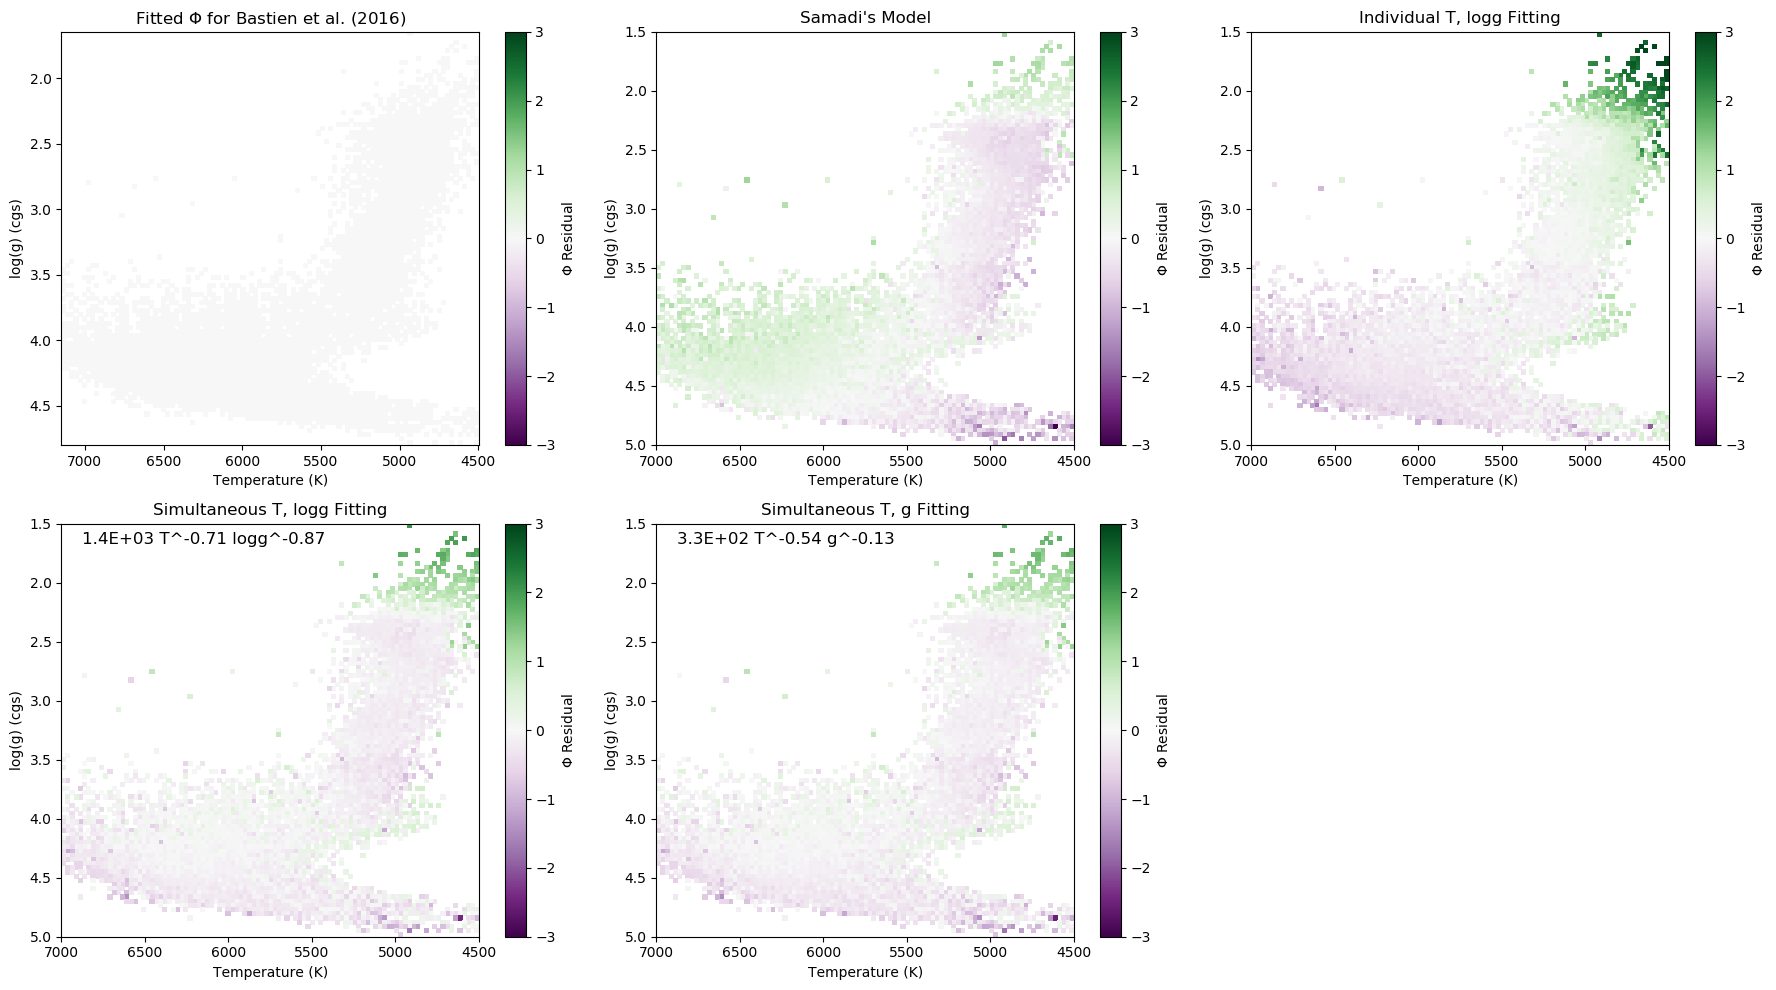

In [6]:
plotter.make_all_the_plots_at_once_resid()
#plt.savefig("fitting_phi_Tg_resid.png", dpi=200)
plt.show()

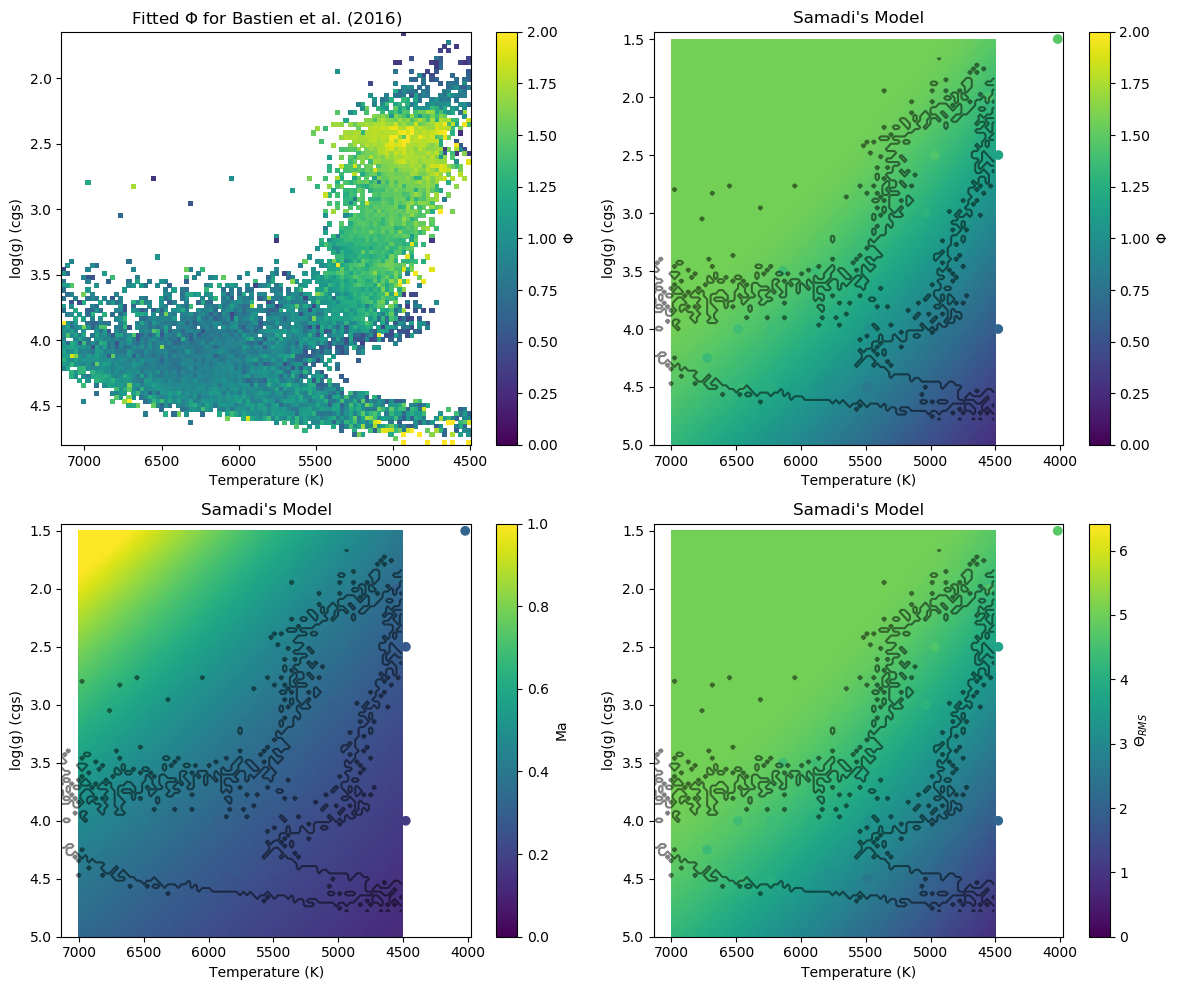

In [7]:
plotter.make_plots_to_compare_samadi()
plt.show()

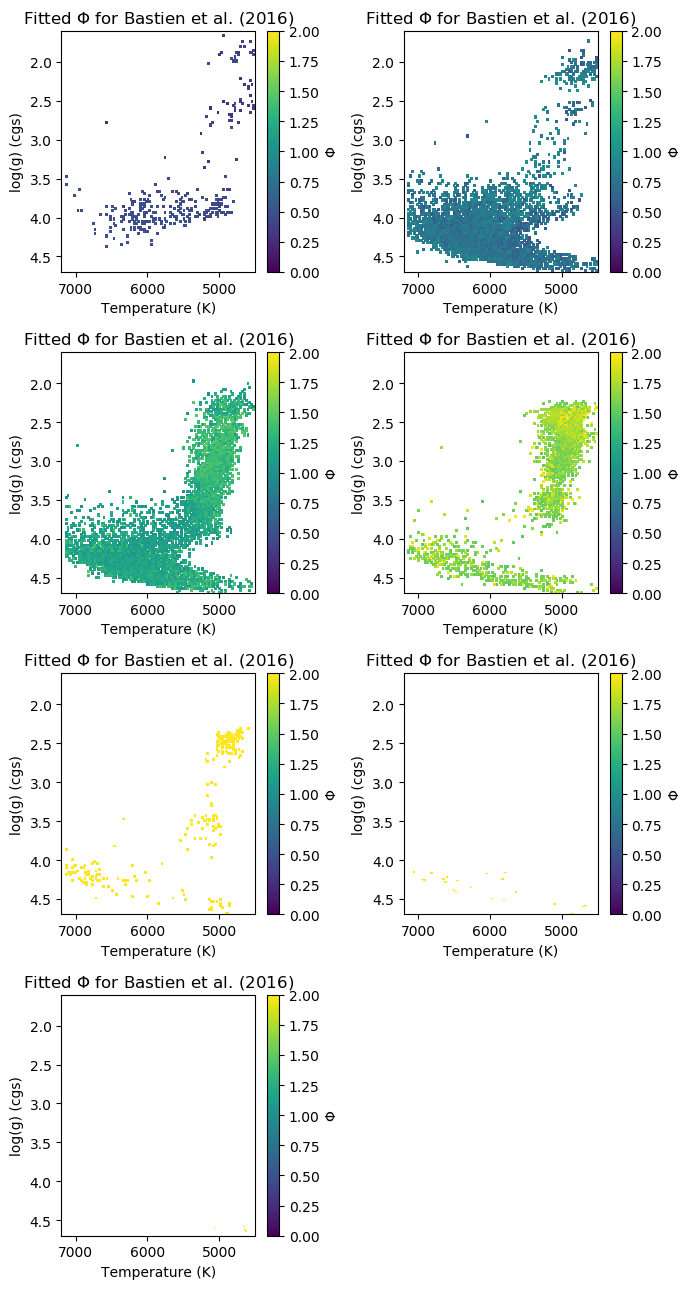

In [11]:
plotter.make_plots_with_slices()
# plt.savefig("slices.png", dpi=200)
plt.show()